# FE 691 Final Project

### Testing Stage for Data


In [159]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import pandas as pd
from yahooquery import Ticker
import numpy as np
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#### Variables

In [778]:
# Can choose variables here then just run everything for testing

# Symbols we are interested in checking
symbols = ['btc-usd', 'mara', 'gbtc', 'riot', 'hut', 'hive', 'gc=f']
# symbols = ['baesy', 'gd', 'hon', 'lhx', 'lmt', 'noc', 'rnmby', 'rtx']

# Date Range of Training
train_start = '2017-01-01'
train_end = '2022-01-01'

# Date Range of Validation
val_start = '2022-01-01'
val_end = '2022-12-01'

# Date Range of Testing
test_start = '2023-01-01'
test_end = '2023-12-01'

# Symbols we want in our pair
stock1 = 'riot'
stock2 = 'mara'

# Selected data-set to use
# Options (close, logclose, ret_cum, logret_cum, ret, log_ret)
option = 'logclose'

#### Data Collection

In [746]:
# Get data on symbols
data = Ticker(symbols)

# Extract the training adjclose data
tr = data.history(start = train_start, end = train_end)
tr_close = pd.DataFrame()
for sym in tr.index.get_level_values(0).unique():
    tr_close[sym] = tr['adjclose'][sym]

tr_close.dropna(inplace = True)

# Extract the validation adjclose data
val = data.history(start = val_start, end = val_end)
val_close = pd.DataFrame()
for sym in val.index.get_level_values(0).unique():
    val_close[sym] = val['adjclose'][sym]

val_close.dropna(inplace = True)

# Extract the testing adjclose data
te = data.history(start = test_start, end = test_end)
te_close = pd.DataFrame()
for sym in te.index.get_level_values(0).unique():
    te_close[sym] = te['adjclose'][sym]

te_close.dropna(inplace = True)

# Get data on benchmarks
bench_syms = [stock1, stock2, 'spy', 'vmnfx']
bench_data = Ticker(bench_syms)

# Extract the training adjclose data
te_bench = bench_data.history(start = test_start, end = test_end)
te_bench_close = pd.DataFrame()
for sym in te_bench.index.get_level_values(0).unique():
    te_bench_close[sym] = te_bench['adjclose'][sym]

te_bench_close.dropna(inplace = True)

#### Correlation Analysis

In [747]:
# Get returns and log returns
ret = tr_close.pct_change().dropna()
logret = np.log(1 + tr_close.pct_change()).dropna()
logret.corr()

,btc-usd,mara,gbtc,riot,hut,hive,gc=f
btc-usd,1.000000,0.488082,0.787810,0.521989,0.503505,0.549321,0.134781
mara,0.488082,1.000000,0.592836,0.720877,0.522064,0.561434,0.076491
gbtc,0.787810,0.592836,1.000000,0.617613,0.556646,0.655152,0.166892
riot,0.521989,0.720877,0.617613,1.000000,0.505984,0.574073,0.123524
hut,0.503505,0.522064,0.556646,0.505984,1.000000,0.527587,0.078910
hive,0.549321,0.561434,0.655152,0.574073,0.527587,1.000000,0.121620
gc=f,0.134781,0.076491,0.166892,0.123524,0.078910,0.121620,1.000000


#### Data Setup

In [748]:
def compute_datasets(close):
    # Get log close
    logclose = np.log(close)

    # Get returns
    ret = close.pct_change().dropna()
    logret = np.log(1 + close.pct_change()).dropna()

    # Get cumulative returns
    logret_cum = np.cumsum(logret)
    ret_cum = np.exp(logret_cum) - 1

    # Establish the key value pairs
    dataset_list = [close, logclose, ret_cum, logret_cum, ret, logret]
    keys = ['close', 'logclose', 'ret_cum', 'logret_cum', 'ret', 'logret']

    # Put into the dictionary
    dataset_dict = {}
    for i, dataset in enumerate(dataset_list):
        dataset_dict[keys[i]] = dataset

    return dataset_dict

In [749]:
# Get all datasets for training and validity testing
tr_datasets = compute_datasets(tr_close)

#### Cointegration Testing

In [750]:
# Perform cointegration testing for all datasets
for key in tr_datasets.keys():
    dataset = tr_datasets[key]
    coint_result = coint_result = ts.coint(dataset[stock1], dataset[stock2])
    print(f'Using {key}: \np-value= {coint_result[1]}\n')

Using close: 
p-value= 0.11150617117480621

Using logclose: 
p-value= 0.07505812026035427

Using ret_cum: 
p-value= 0.1115580426341386

Using logret_cum: 
p-value= 0.07142870001892224

Using ret: 
p-value= 0.0

Using logret: 
p-value= 0.0



#### ADF Testing

In [751]:
# Performs ADF testing given the data set and the stocks to test
def adf_test(data, stock1, stock2, verbose = False, plot = False):
    # Build the regression data set
    x = data[stock1].to_numpy().reshape(-1, 1)
    y = data[stock2].to_numpy()

    # Create the linear model
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()

    # Get spread
    c = results.params[0]
    alpha = results.params[1]
    resid = y - results.predict(x).T
    resid = pd.Series(resid, index = data.index)

    # # Compute the ADF test
    adf = adfuller(resid)

    # Plot spread
    if plot:
      plt.figure()
      plt.plot(resid)

      # Plot details
      plt.xlabel('Date')
      plt.ylabel('Residual')
      plt.title(f'{stock1} vs {stock2}')

    if verbose:
      print(f"ADF Statistic: {adf[0]}")
      print(f"P-value: {adf[1]}")
      print(f"Critical Values:{adf[4]}\n")

    return model, resid, adf

Using close
ADF Statistic: -2.7610003221415824
P-value: 0.06406414916095278
Critical Values:{'1%': -3.4373257950466174, '5%': -2.864619627202065, '10%': -2.568409774784971}

Using logclose
ADF Statistic: -3.099698471989498
P-value: 0.026575510954999763
Critical Values:{'1%': -3.4371658366910216, '5%': -2.8645490899304784, '10%': -2.5683722036989813}

Using ret_cum
ADF Statistic: -2.7590751751897113
P-value: 0.06436154889252974
Critical Values:{'1%': -3.4373332444652944, '5%': -2.864622912101569, '10%': -2.568411524473161}

Using logret_cum
ADF Statistic: -3.1191900975470594
P-value: 0.02516524716295994
Critical Values:{'1%': -3.4371729482129885, '5%': -2.8645522259969534, '10%': -2.568373874086242}

Using ret
ADF Statistic: -31.55548448442576
P-value: 0.0
Critical Values:{'1%': -3.4371729482129885, '5%': -2.8645522259969534, '10%': -2.568373874086242}

Using logret
ADF Statistic: -32.106771070330666
P-value: 0.0
Critical Values:{'1%': -3.4371729482129885, '5%': -2.8645522259969534, '10

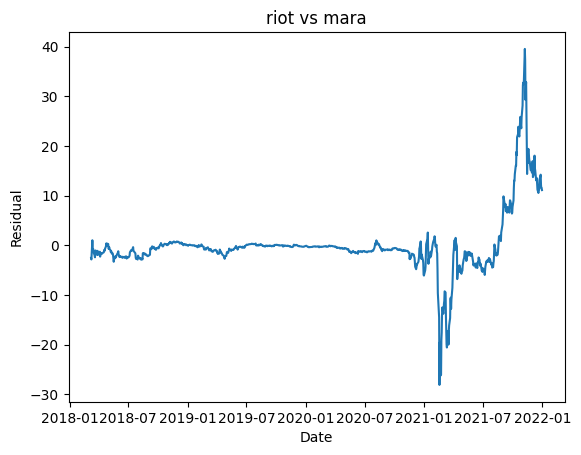

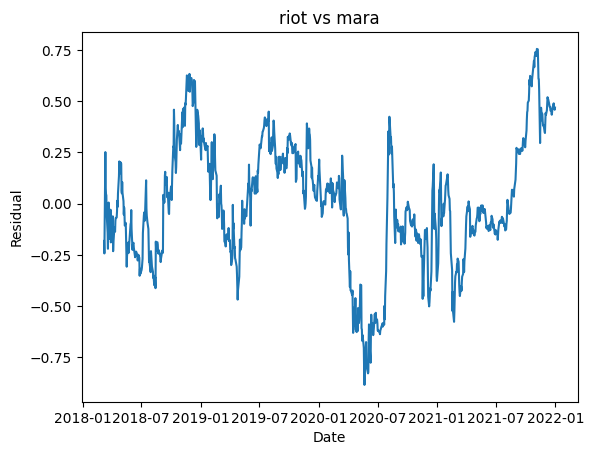

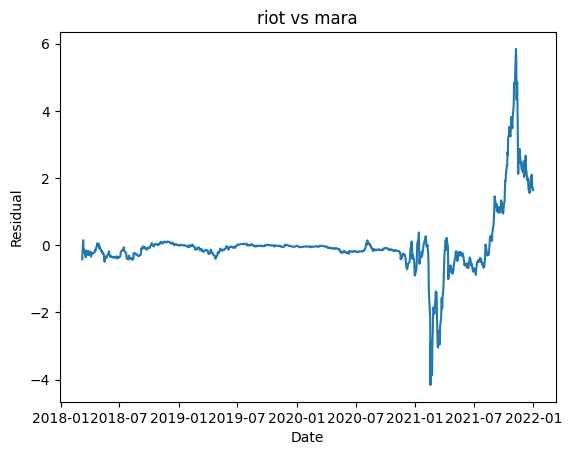

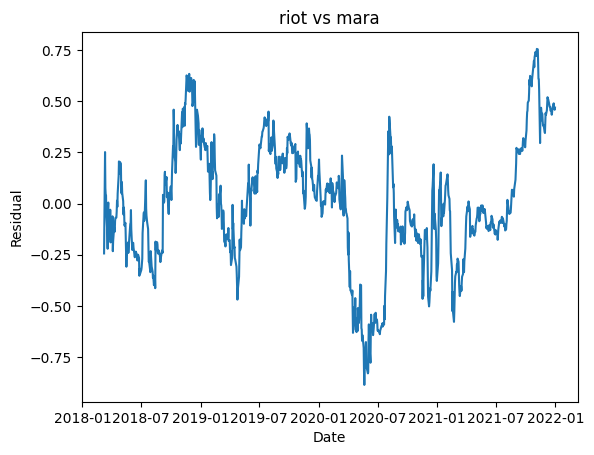

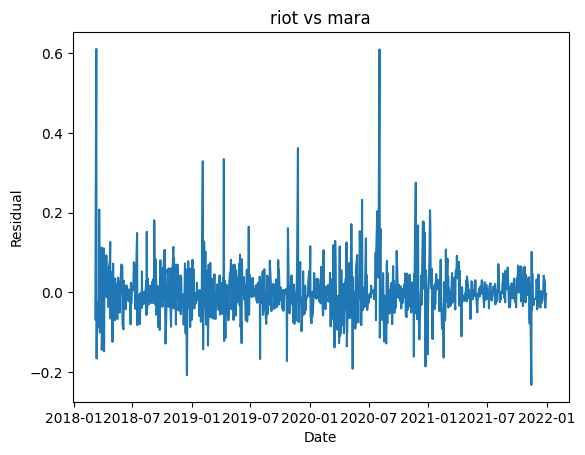

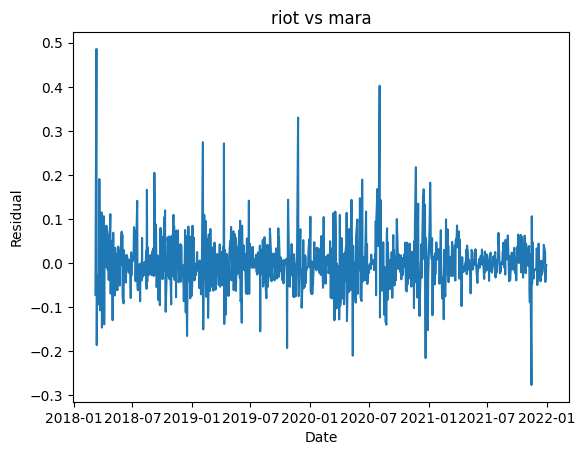

In [752]:
# Perform ADF testing for all training datasets
for key in tr_datasets.keys():
    dataset = tr_datasets[key]
    print(f'Using {key}')
    adf_test(dataset, stock1, stock2, verbose = True, plot = True)

## Backtesting

#### Variables

#### Test Data Collection

In [753]:
# Get all datasets for testing using same process as training
te_datasets = compute_datasets(te_close)

In [754]:
# Perform ADF testing for all testing datasets
# Just for visual inspection

# for key in te_datasets.keys():
#     dataset = te_datasets[key]
#     print(f'Using {key}')
#     adf_test(dataset, stock1, stock2, verbose = True, plot = True)

#### Signal Generation

In [772]:
# Generate plain signal time series:
# More advanced signals for less fees and holding tracking
# Delta for portfolio entry and omega is portfolio exit
# Omega being an acceptable range around 0
# 1 = short stock2 long stock1
# 2 = long stock2 short stock1
# 3 = portfolio
# 0 = hold / do nothing
def gen_plain_sigs(train_data, test_data, stock1, stock2):
    # Get the adf residuals using training data
    # in order to generate the delta and omegas
    _, train_resid, _ = adf_test(train_data, stock1, stock2)
    delta = 0.4 * train_resid.std()
    omega = 0.2 * train_resid.std()

    # Get the adf residuals using test data for backtesting
    _, test_resid, _ = adf_test(test_data, stock1, stock2)

    # Current active code of portfolio
    trade_code = 0

    # Generate the signals by comparing residuals to delta
    signals = pd.Series(index = test_resid.index)
    for date, res in test_resid.items():
        if trade_code == 0:
            if res >= delta:
                signals[date] = 1
                trade_code = 1
            elif res <= -delta:
                signals[date] = 2
                trade_code = 2
            else:
                signals[date] = 0
        else:
            if (trade_code == 1 and res <= omega) or (trade_code == 2 and res >= -omega):
                signals[date] = 3
                trade_code = 0
            else:
                signals[date] = 0

    return signals

In [773]:
# Get true reversion labels
def get_true_labels(train_data, train_resid, stock1, period):
    # Get stock data
    s1 = train_data[stock1]
   
    labels = pd.Series(index = train_resid.index)
    for i in range(len(train_resid) - 10):
        date = train_resid.index[i]

        # Get current conditions
        spread_entry = train_resid.iloc[i]
        s1_entry = s1.iloc[i]

        # Get later conditions
        spread_delta = np.abs(train_resid.iloc[i + period] - spread_entry)
        s1_delta = np.abs(s1.iloc[i + period] - s1_entry)
        if s1_delta > 0.8 * spread_delta:
            labels[date] = 5
        elif s1_delta > 0.6 * spread_delta and s1_delta <= 0.8 * spread_delta:
            labels[date] = 4
        elif s1_delta > 0.4 * spread_delta and s1_delta <= 0.6 * spread_delta:
            labels[date] = 3
        elif s1_delta > 0.2 * spread_delta and s1_delta <= 0.5 * spread_delta:
            labels[date] = 2
        else:
            labels[date] = 1
                
    return labels


In [774]:
# Generate neural network signal time series:
# More advanced signals for less fees and holding tracking
# Delta for portfolio entry and omega is portfolio exit
# Omega being an acceptable range around 0
# 1 = short stock2 long stock1
# 2 = long stock2 short stock1
# 3 = portfolio
# 0 = hold / do nothing
def gen_ffnn_sigs(train_data, test_data, tr_datasets, te_datasets, stock1, stock2):
    # Get plain signals and generate true labels for reversion
    _, train_resid, _ = adf_test(train_data, stock1, stock2)
    labels = get_true_labels(train_data, train_resid, stock1, 10)
    signals = gen_plain_sigs(train_data, test_data, stock1, stock2)

    features = pd.concat([signals, tr_datasets['logret'], labels])

    return features

#### Backtesting Code

In [775]:
# Plain pairs trading algorithm
def plain_pt(logret, signals, stock1, stock2, fee_style = 'flat', fee = 0, principal = 1000):
    curr_val = principal
    real_val = pd.Series(index = signals.index, dtype = 'float')
    port_val = pd.DataFrame(columns = [stock1, stock2], index = signals.index)

    # Get simple returns
    ret = np.exp(logret) - 1

    # Current active code of portfolio
    trade_code = 0

    # Backtesting portion of code
    # Uses the same logic in the signals to trade
    for i in range(len(signals)):
        if trade_code == 0:
            real_val.iloc[i] = curr_val
            if signals.iloc[i] == 1:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 1
            elif signals.iloc[i] == 2:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 2
            else:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
        else:
            if trade_code == 1:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 - ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 + ret.iloc[i][stock1])
            elif trade_code == 2:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 + ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 - ret.iloc[i][stock1])

            curr_val = port_val.iloc[i][stock2] + port_val.iloc[i][stock1]
            real_val.iloc[i] = curr_val

            if signals.iloc[i] == 3:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
                trade_code = 0

    real_ret = real_val.pct_change().dropna()
    return real_val, real_ret

In [776]:
# NN pairs trading algorithm
def nn_pt(logret, signals, stock1, stock2, fee_style = 'flat', fee = 0, principal = 1000):
    curr_val = principal
    real_val = pd.Series(index = signals.index, dtype = 'float')
    port_val = pd.DataFrame(columns = [stock1, stock2], index = signals.index)

    # Get simple returns
    ret = np.exp(logret) - 1

    # Current active code of portfolio
    trade_code = 0

    # Backtesting portion of code
    # Uses the same logic in the signals to trade
    for i in range(len(signals)):
        if trade_code == 0:
            real_val.iloc[i] = curr_val
            if signals.iloc[i] == 1:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 1
            elif signals.iloc[i] == 2:
                port_val.iloc[i][stock2] = curr_val * 0.5
                port_val.iloc[i][stock1] = curr_val * 0.5
                trade_code = 2
            else:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
        else:
            if trade_code == 1:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 - ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 + ret.iloc[i][stock1])
            elif trade_code == 2:
                port_val.iloc[i][stock2] = port_val.iloc[i-1][stock2] * (1 + ret.iloc[i][stock2])
                port_val.iloc[i][stock1] = port_val.iloc[i-1][stock1] * (1 - ret.iloc[i][stock1])

            curr_val = port_val.iloc[i][stock2] + port_val.iloc[i][stock1]
            real_val.iloc[i] = curr_val

            if signals.iloc[i] == 3:
                port_val.iloc[i][stock2] = 0
                port_val.iloc[i][stock1] = 0
                trade_code = 0

    real_ret = real_val.pct_change().dropna()
    return real_val, real_ret

##### FFNN Pairs Trading Backtest

In [777]:
# Compute signals for test data models
ffnn_signals = pd.DataFrame()
ffnn_signals = gen_ffnn_sigs(tr_datasets[option], te_datasets[option], tr_datasets, te_datasets, stock1, stock2)
ffnn_signals.dropna(inplace = True)
ffnn_signals

NameError: name 'option' is not defined

##### Plain Pairs Trading Backtest

In [779]:
# Compute signals for test data models
te_signals = pd.DataFrame()
te_signals[option] = gen_plain_sigs(tr_datasets[option], te_datasets[option], stock1, stock2)
te_signals.dropna(inplace = True)

In [780]:
# Perform backtesting
val, ret = plain_pt(te_datasets['logret'], te_signals[option], stock1, stock2)
te_backtest_cum_ret = pd.DataFrame(ret, columns = [option])
te_backtest_val = pd.DataFrame(val, columns = [option])
te_backtest_cum_ret = (te_backtest_cum_ret + 1).cumprod()

In [ ]:
# Get benchmark performance
te_bench_ret = te_bench_close.pct_change().dropna()
te_bench_cum_ret = (te_bench_ret + 1).cumprod()

Text(0.5, 1.0, 'Test Portfolio Value with Principal = $1000')

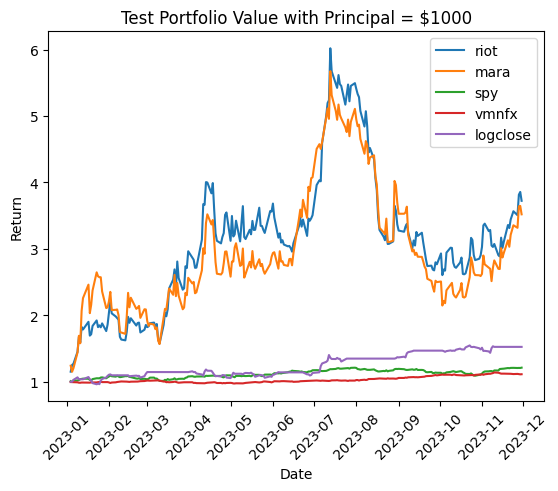

In [ ]:
# Combine all test data
te_comb_cum_ret = pd.concat([te_bench_cum_ret, te_backtest_cum_ret], axis = 'columns')
te_comb_cum_ret.plot()

# Plot details
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Test Portfolio Value with Principal = $1000')

Text(0.5, 1.0, 'Portfolio Returns vs SPY and VMNFX')

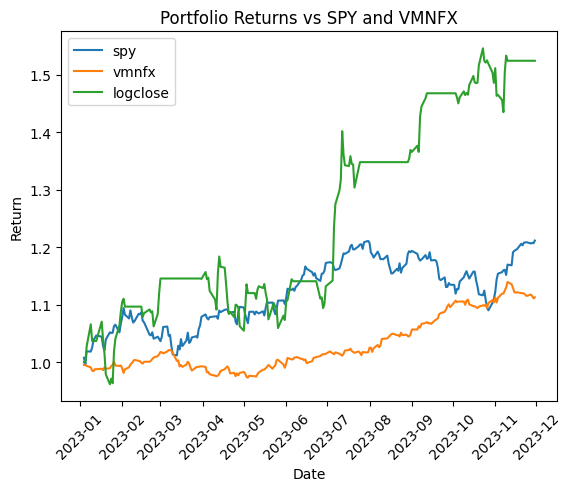

In [ ]:
te_comb_cum_ret_small = te_comb_cum_ret.drop(columns = [stock1, stock2])
te_comb_cum_ret_small.plot()

# Plot details
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Return')
plt.title(f'Portfolio Returns vs SPY and VMNFX')

## Strategy Performance Analysis

In [ ]:
# Calculate the daily volatiltiy of data over <period> days
def volatility(data, period):
    # If period = -1 use entire data
    if period == -1:
        return data.std()

    # Else calculate series of volatility
    vol = pd.Series(dtype = 'object', name = 'vol')
    for t, data_ind in enumerate(np.arange(period, len(data))):
        vol.loc[t] = data[data_ind - period: data_ind].std()

    return vol

In [ ]:
# Computes the value at risk across data for every <period> days
def value_at_risk(value, ret, peariod, alpha):
    var = pd.Series(dtype = 'object', name = 'value_at_risk')
    for t, data_ind in enumerate(np.arange(period, len(ret))):
        segment = ret[data_ind - period: data_ind]
        var.loc[t] = np.percentile(segment, 100 * (1 - alpha)) * value[t]

In [ ]:
# Get max drawdown calculated for days = period
def max_dd(data, period):
    drawdown = pd.Series(dtype = 'object', name = 'drawdown')
    for t, data_ind in enumerate(np.arange(period, len(data))):
        segment = data[data_ind - period: data_ind]
        peak_val = segment.max()
        peak_val_ind = segment.argmax()
        segment = segment[peak_val_ind:]
        low_val = segment.min()
        drawdown.loc[t] = (low_val - peak_val) / peak_val
    return drawdown.min()

In [ ]:
def strat_summary(val, ret):
    # Daily and annualized return metrics
    amean = ret.mean()
    amean_ann = amean * np.sqrt(252)
    gmean = (ret + 1).product() ** (1 / len(ret)) - 1
    gmean_ann =  gmean * np.sqrt(252)
    min_ret = ret.min()
    min_ret_ann = min_ret * np.sqrt(252)

    # Maximum 10 days drawdown
    max_dd_10 = max_dd(val, 10)

    # Volatility and Sharpe Ratio overall and annualized
    vol = volatility(ret, -1)
    vol_ann = vol * np.sqrt(252 / len(ret))
    sharpe = amean / vol
    sharpe_ann = amean_ann / vol_ann

    # Skewness, Kurtosis
    skewness = ret.skew()
    kurtosis = ret.kurtosis()

    return pd.Series([amean, amean_ann, gmean, gmean_ann, min_ret, min_ret_ann, max_dd_10, vol,
                    vol_ann, sharpe, sharpe_ann, skewness, kurtosis],
                index = ['daily_amean', 'daily_amean_ann', 'daily_gmean', 'daily_gmean_ann',
                            'daily_min_ret', 'daily_min_ret_ann', 'max_dd_10', 'vol', 'vol_ann',
                            'sharpe', 'sharpe_ann', 'skewness', 'kurtosis'])

In [ ]:
# Get returns of all time series
te_comb_ret = pd.concat([te_backtest_ret, te_bench_ret], axis = 'columns').dropna()
te_comb_val = pd.concat([te_backtest_val, te_bench_close], axis = 'columns').dropna()

In [ ]:
# Show summaries of all the strategies
summaries = pd.DataFrame()
for col in te_comb_ret.columns:
    summary = strat_summary(te_comb_val[col], te_comb_ret[col])
    summaries = pd.concat([summaries, summary], axis = 'columns')
summaries.columns = te_comb_val.columns
summaries.drop(['close', 'logclose', 'logret_cum', 'logret'], axis = 'columns', inplace = True)
summaries

KeyError: 'close'